# 2b. IID sampling according to various densities & trajectories

This notebook is intended to demonstrate the interest of using _iid variable density sampling_
either from:
* **optimal distributions** from the CS theory on orthonormal systems for Shannon wavelets derived in:
    -   Chauffert et al, "Variable density compressed sensing in MRI. Theoretical vs heuristic sampling strategies", Proc. 10th IEEE ISBI 2013: 298-301
    -  Chauffert et al, "Variable Density Sampling with Continuous Trajectories" SIAM Imaging Sci, 2014;7(4):1992-1992)

* or from handcrafted densities parameterized by the decay $\eta$:

$$
p(k_x,k_y) =1/\left(k_x^2+k_y^2\right)^{\eta/2}, \quad \eta \simeq 3.
$$

- Author: Guillaume Daval-Frérot, Nicolas Chauffert and Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 04/02/2025

## Install dependencies

***On Google Colab, it is required to install the following dependencies in order for the notebook to work***

In [ ]:
!pip install mri-nufft[finufft,gpunufft] pyWavelets pysap-mri brainweb-dl "numpy<2.0" python-pysap 

In [ ]:
# We will also dowload extra data if needed:

(256, 256)


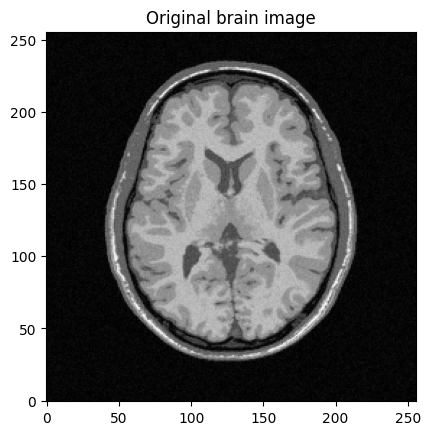

In [1]:
#DISPLAY T2* MR IMAGE
%matplotlib inline

import numpy as np
import os.path as op
import os
import math
import cmath
import matplotlib.pyplot as plt
import sys

import brainweb_dl as bwdl

import mrinufft as mn
from mrinufft import get_density, displayConfig
from mrinufft.trajectories import display
from mrinufft.density import voronoi
from mrinufft.trajectories import initialize_2D_spiral
from mrinufft.trajectories.display import display_2D_trajectory


plt.rcParams["image.origin"]="lower"
plt.rcParams["image.cmap"]='Greys_r'

mri_img = bwdl.get_mri(4, "T1")[80,:,:].astype(np.float32)
print(mri_img.shape)
img_size = mri_img.shape[0]
plt.figure()
plt.imshow(abs(mri_img))
plt.title("Original brain image")
plt.show()

In [51]:
# util functions
from matplotlib import colors

# Display parameters
figure_size = 5.5  # Figure size for trajectory plots
subfigure_size = 3  # Figure size for subplots
one_shot = 0  # Highlight one shot in particular

def show_density(density, figure_size, *, log_scale=False):
    density = density.T[::-1]

    plt.figure(figsize=(figure_size, figure_size))
    if log_scale:
        plt.imshow(density, cmap="jet", norm=colors.LogNorm())
    else:
        plt.imshow(density, cmap="jet")

    ax = plt.gca()
    ax.set_xlabel("kx", fontsize=displayConfig.fontsize)
    ax.set_ylabel("ky", fontsize=displayConfig.fontsize)
    ax.set_aspect("equal")

    plt.axis(False)
    plt.colorbar()
    plt.show()


def show_densities(function, arguments, subfig_size, *, log_scale=False):
    # Initialize k-space densities with varying option
    densities = [function(arg).T[::-1] for arg in arguments]

    # Plot the trajectories side by side
    fig, axes = plt.subplots(
        1,
        len(densities),
        figsize=(len(densities) * subfig_size, subfig_size),
        constrained_layout=True,
    )

    for ax, arg, density in zip(axes, arguments, densities):
        ax.set_title(str(arg), fontsize=displayConfig.fontsize)
        ax.set_xlabel("kx", fontsize=displayConfig.fontsize)
        ax.set_ylabel("ky", fontsize=displayConfig.fontsize)
        ax.set_aspect("equal")
        if log_scale:
            ax.imshow(density, cmap="jet", norm=colors.LogNorm())
        else:
            ax.imshow(density, cmap="jet")
        ax.axis(False)
    plt.show()


def show_locations(function, arguments, subfig_size, *, log_scale=False):
    # Initialize k-space locations with varying option
    locations = [function(arg) for arg in arguments]

    # Plot the trajectories side by side
    fig, axes = plt.subplots(
        1,
        len(locations),
        figsize=(len(locations) * subfig_size, subfig_size),
        constrained_layout=True,
    )

    for ax, arg, location in zip(axes, arguments, locations):
        ax.set_title(str(arg), fontsize=displayConfig.fontsize)
        ax.set_xlim(-1.05 * KMAX, 1.05 * KMAX)
        ax.set_ylim(-1.05 * KMAX, 1.05 * KMAX)
        ax.set_xlabel("kx", fontsize=displayConfig.fontsize)
        ax.set_ylabel("ky", fontsize=displayConfig.fontsize)
        ax.set_aspect("equal")
        ax.scatter(location[..., 0], location[..., 1], s=3)
    plt.show()

In [3]:
# Density parameters
shape_2d = (100, 100)
shape_3d = (100, 100, 100)

## Cutoff/decay density

Create a density composed of a central constant-value ellipsis defined by a `cutoff` ratio, followed by a polynomial decay over outer regions as defined in [Cha+22].

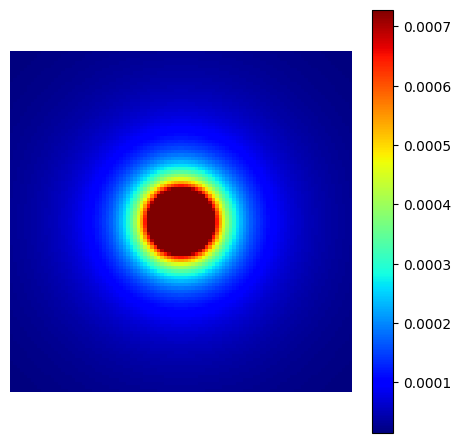

In [5]:
cutoff_density = mn.create_cutoff_decay_density(shape=shape_2d, cutoff=0.2, decay=2)
show_density(cutoff_density, figure_size=figure_size)

## cutoff (float)


The k-space radius `cutoff` ratio between 0 and 1 within which density remains uniform and beyond which it decays. It is modulated by `resolution` to create ellipsoids.

The `mrinufft.create_polynomial_density` simply calls this function with `cutoff=0`.

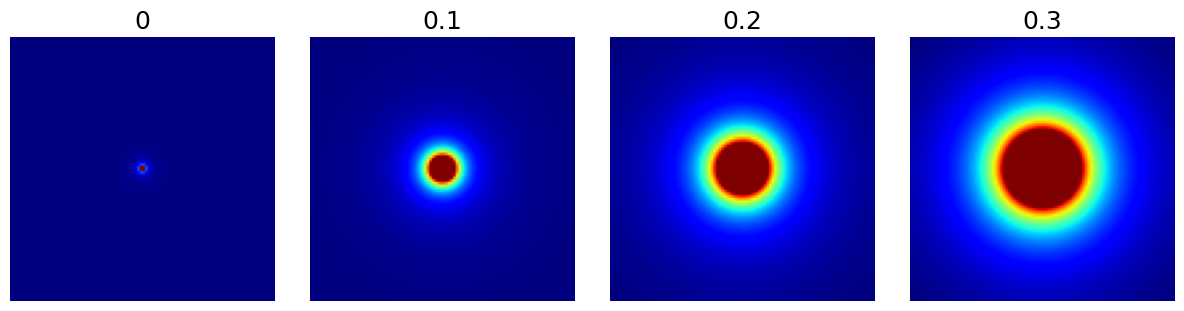

In [6]:
arguments = [0, 0.1, 0.2, 0.3]
function = lambda x: mn.create_cutoff_decay_density(
    shape=shape_2d,
    cutoff=x,
    decay=2,
)
show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
)

## decay (float)

The polynomial `decay` in density beyond the cutoff ratio. It can be zero or negative as shown below, but most applications are expected have decays in the positive range.

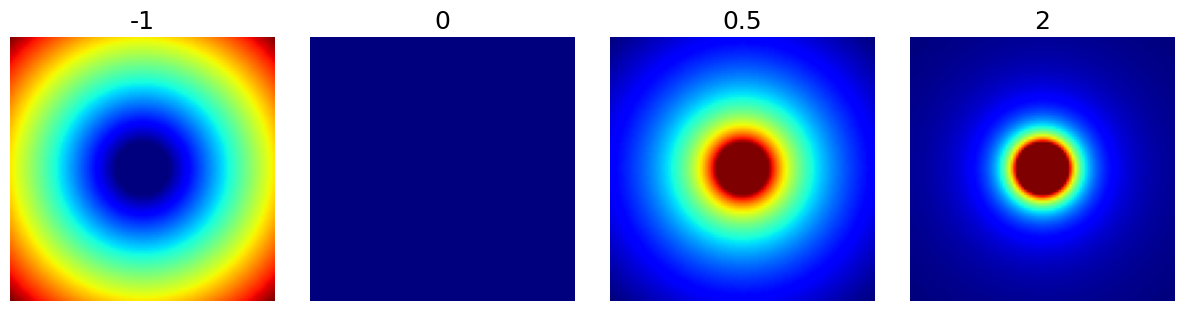

In [7]:
arguments = [-1, 0, 0.5, 2]
function = lambda x: mn.create_cutoff_decay_density(
    shape=shape_2d,
    cutoff=0.2,
    decay=x,
)
show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
)

## resolution (tuple)

Resolution scaling factors for each dimension of the density grid, by default `None`. Note on the example below that the unit doesn’t matter because `cutoff` is a ratio and `decay` is an exponent, so only the relative factor between the dimensions is important.

This argument can be used to handle anisotropy but also to produce ellipsoidal densities.

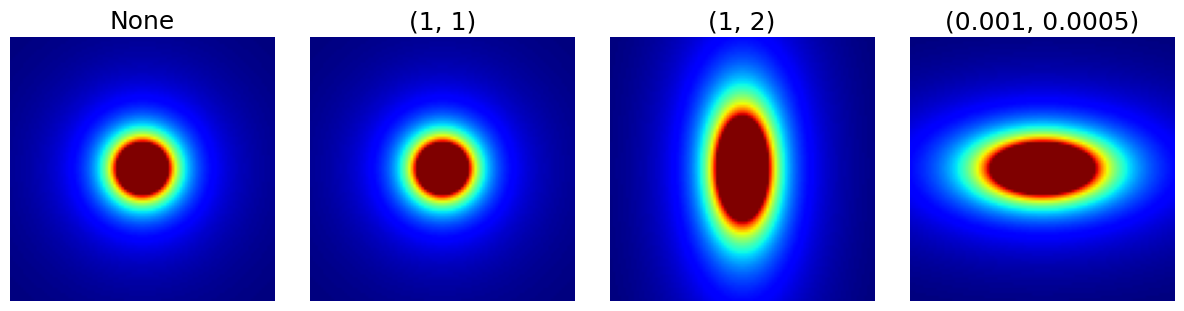

In [8]:
arguments = [None, (1, 1), (1, 2), (1e-3, 0.5e-3)]
function = lambda x: mn.create_cutoff_decay_density(
    shape=shape_2d,
    cutoff=0.2,
    decay=2,
    resolution=x,
)
show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
)

## Energy-based density

A common intuition is to consider that the sampling density should be proportional to the k-space amplitude. It can be learned from existing datasets and used for new acquisitions.

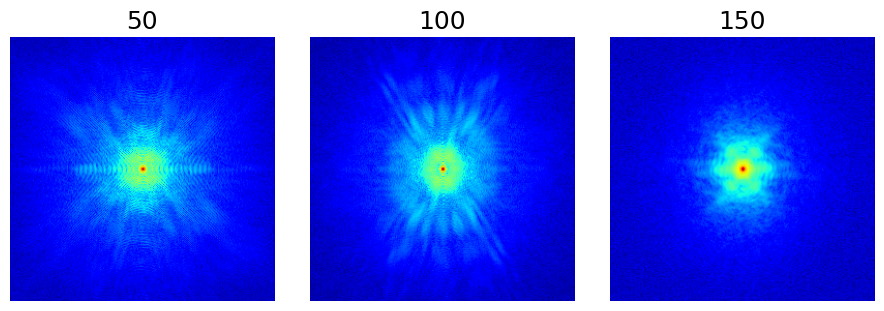

In [52]:
arguments = [50, 100, 150]
function = lambda x: mn.create_energy_density(dataset=bwdl.get_mri(4, "T1")[x : x + 20])
show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
    log_scale=True,
)

#dataset = bwdl.get_mri(4, "T1")[:, ::2, ::2]
#energy_density = mn.create_energy_density(dataset=dataset)
#show_density(energy_density, figure_size=figure_size, log_scale=True)

## Chauffert’s density

This is a reproduction of the proposition from [CCW13]. A sampling density is derived from compressed sensing equations to maximize guarantees of exact image recovery for a specified sparse wavelet domain decomposition.

This principle is valid for any linear transform but for convenience it was limited to wavelets as in the original implementation.

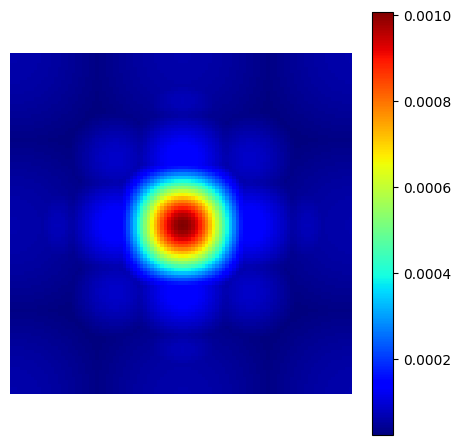

In [20]:
chauffert_density = mn.create_chauffert_density(
    shape=shape_2d,
    wavelet_basis="haar",
    nb_wavelet_scales=3,
)
show_density(chauffert_density, figure_size=figure_size)

## Wavelet_basis (str)

The wavelet basis to use for wavelet decomposition, either as a built-in wavelet name from the PyWavelets package or as a custom `pywt.Wavelet object`.

/volatile/home/pc174679/codes/venv/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


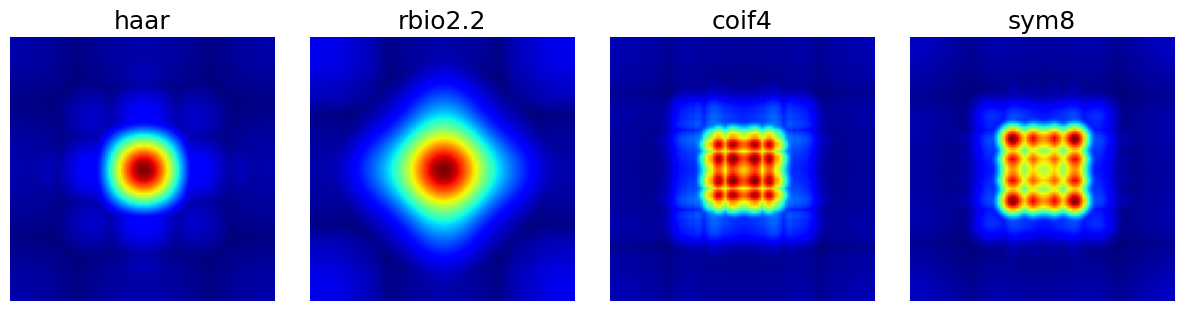

In [21]:
arguments = ["haar", "rbio2.2", "coif4", "sym8"]
function = lambda x: mn.create_chauffert_density(
    shape=shape_2d,
    wavelet_basis=x,
    nb_wavelet_scales=3,
)
show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
)

## nb_wavelet_scales (int)

The number of wavelet scales to be used in the decomposition.



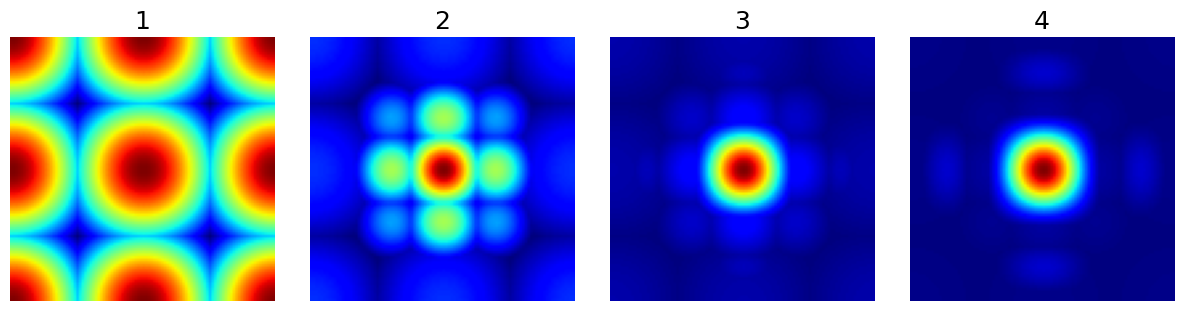

In [22]:
arguments = [1, 2, 3, 4]
function = lambda x: mn.create_chauffert_density(
    shape=shape_2d,
    wavelet_basis="haar",
    nb_wavelet_scales=x,
)
show_densities(
    function,
    arguments,
    subfig_size=subfigure_size,
)

## Custom density

Any density can be defined and later used for sampling and trajectories.

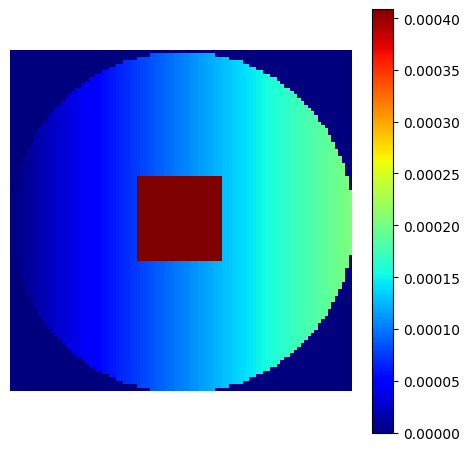

In [23]:
# Linear gradient
density = np.tile(np.linspace(0, 1, shape_2d[1])[:, None], (1, shape_2d[0]))
# Square center
density[
    3 * shape_2d[0] // 8 : 5 * shape_2d[0] // 8,
    3 * shape_2d[1] // 8 : 5 * shape_2d[1] // 8,
] = 2
# Outer circle
density = np.where(
    np.linalg.norm(np.indices(shape_2d) - shape_2d[0] / 2, axis=0) < shape_2d[0] / 2,
    density,
    0,
)
# Normalization
custom_density = density / np.sum(density)

show_density(custom_density, figure_size=figure_size)

# Sampling

In this section we present random, pseudo-random and algorithm-based sampling methods. The examples are based on a few densities picked from the ones presented above.

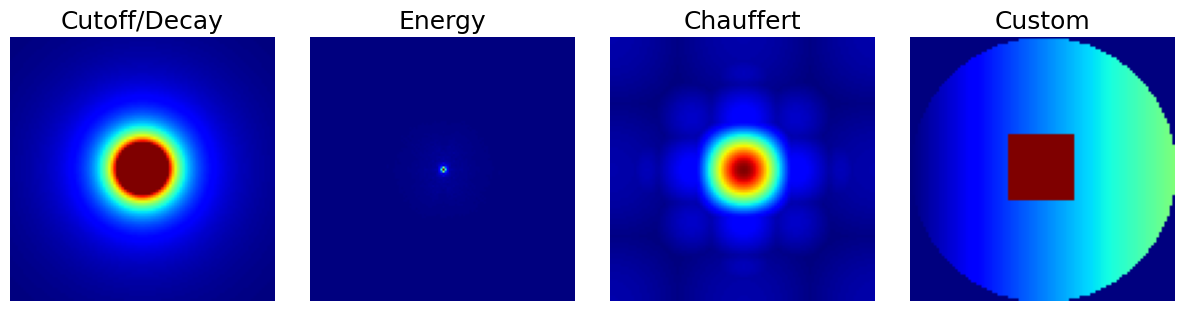

In [25]:
densities = {
    "Cutoff/Decay": cutoff_density,
    "Energy": energy_density,
    "Chauffert": chauffert_density,
    "Custom": custom_density,
}

arguments = densities.keys()
function = lambda x: densities[x]
show_densities(function, arguments, subfig_size=subfigure_size)

## Random sampling

This sampling simply consists of a weighted pseudo-random selection from the density grid locations.

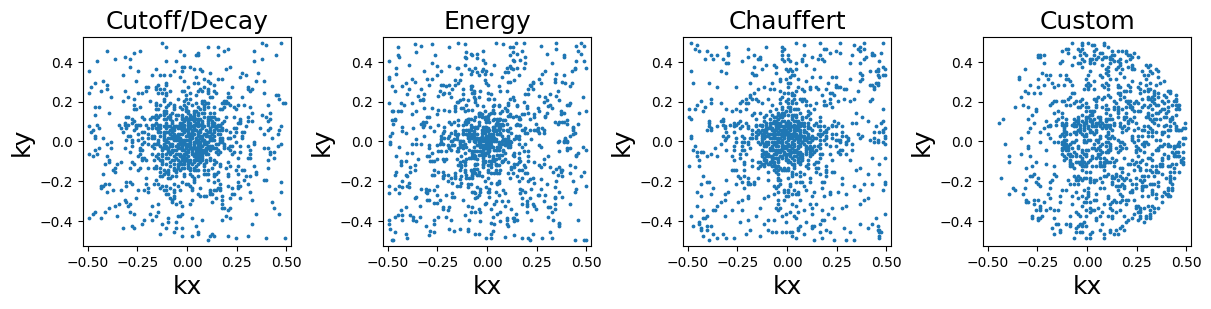

In [38]:
from mrinufft.trajectories.utils import KMAX
arguments = densities.keys()

# Trajectory parameters
Nc = 20  # Number of shots
Ns = 50  # Number of samples per shot


function = lambda x: mn.sample_from_density(Nc * Ns, densities[x], method="random")
show_locations(function, arguments, subfig_size=subfigure_size)

## Lloyd’s sampling

This sampling is based on a Voronoi/Dirichlet tesselation using Lloyd’s weighted KMeans algorithm. The implementation is based on `sklearn.cluster.KMeans` in 2D and `sklearn.cluster.BisectingKMeans` in 3D, mostly to reduce computation times in the most demanding cases.

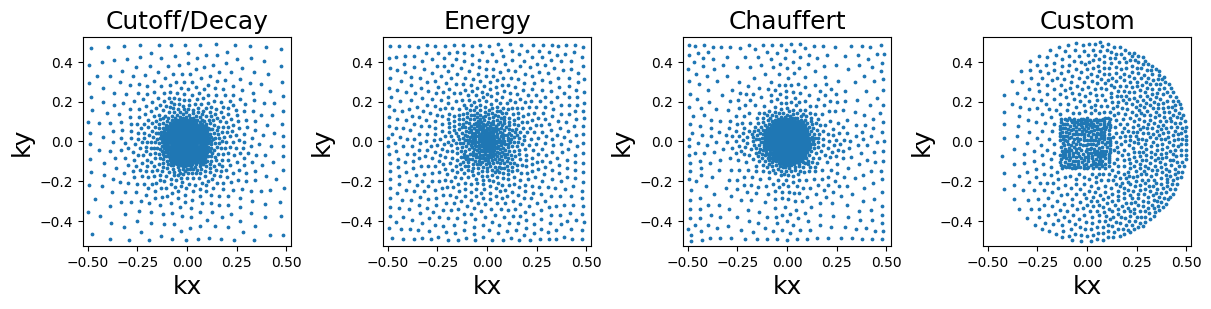

In [39]:
arguments = densities.keys()
function = lambda x: mn.sample_from_density(Nc * Ns, densities[x], method="lloyd")
show_locations(function, arguments, subfig_size=subfigure_size)

# Density-based trajectories

In this section we present 2D and 3D trajectories based on arbitrary densities, and also sampling for some of them.

In [40]:
def show_trajectory(trajectory, one_shot, figure_size):
    if trajectory.shape[-1] == 2:
        ax = display_2D_trajectory(
            trajectory, size=figure_size, one_shot=one_shot % trajectory.shape[0]
        )
        ax.set_aspect("equal")
        plt.tight_layout()
        plt.show()
    else:
        ax = display_3D_trajectory(
            trajectory,
            size=figure_size,
            one_shot=one_shot % trajectory.shape[0],
            per_plane=False,
        )
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.1)
        plt.show()


def show_trajectories(
    function, arguments, one_shot, subfig_size, dim="3D", axes=(0, 1)
):
    # Initialize trajectories with varying option
    trajectories = [function(arg) for arg in arguments]

    # Plot the trajectories side by side
    fig = plt.figure(
        figsize=(len(trajectories) * subfig_size, subfig_size),
        constrained_layout=True,
    )
    subfigs = fig.subfigures(1, len(trajectories), wspace=0)
    for subfig, arg, traj in zip(subfigs, arguments, trajectories):
        if dim == "3D" and traj.shape[-1] == 3:
            ax = display_3D_trajectory(
                traj,
                size=subfig_size,
                one_shot=one_shot % traj.shape[0],
                subfigure=subfig,
                per_plane=False,
            )
        else:
            ax = display_2D_trajectory(
                traj[..., axes],
                size=subfig_size,
                one_shot=one_shot % traj.shape[0],
                subfigure=subfig,
            )
        labels = ["kx", "ky", "kz"]
        ax.set_xlabel(labels[axes[0]], fontsize=displayConfig.fontsize)
        ax.set_ylabel(labels[axes[1]], fontsize=displayConfig.fontsize)
        ax.set_aspect("equal")
        ax.set_title(str(arg), fontsize=displayConfig.fontsize)
    plt.show()


## Random walks

This is an adaptation of the proposition from [Cha+14]. It creates a trajectory by walking randomly to neighboring points following a provided sampling density.

This implementation is different from the original proposition: trajectories are continuous with a fixed length instead of making random jumps to other locations, and an option is provided to have pseudo-random walks to improve coverage.

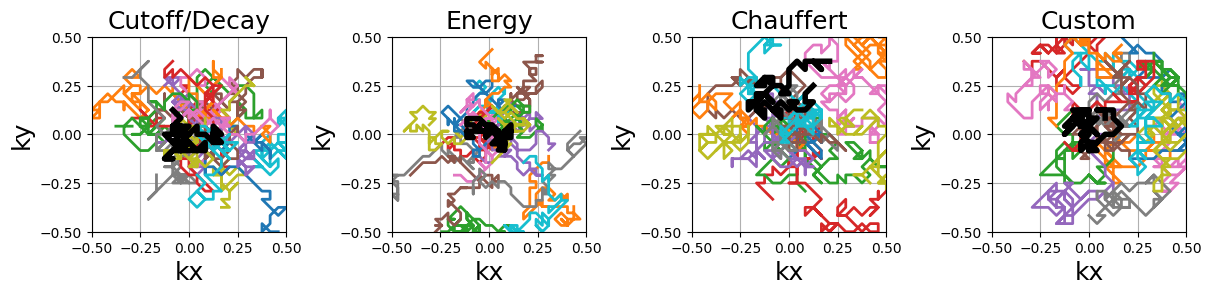

In [41]:
arguments = densities.keys()
function = lambda x: mn.initialize_2D_random_walk(
    Nc, Ns, density=densities[x][::4, ::4]
)
show_trajectories(function, arguments, one_shot=one_shot, subfig_size=subfigure_size)

The starting shot positions can be modified to follow Lloyd’s sampling method rather than the default random approach, resulting in more evenly spaced shots that still respect the prescribed density. Additional `kwargs` can be provided to set the arguments in `mrinufft.sample_from_density`.

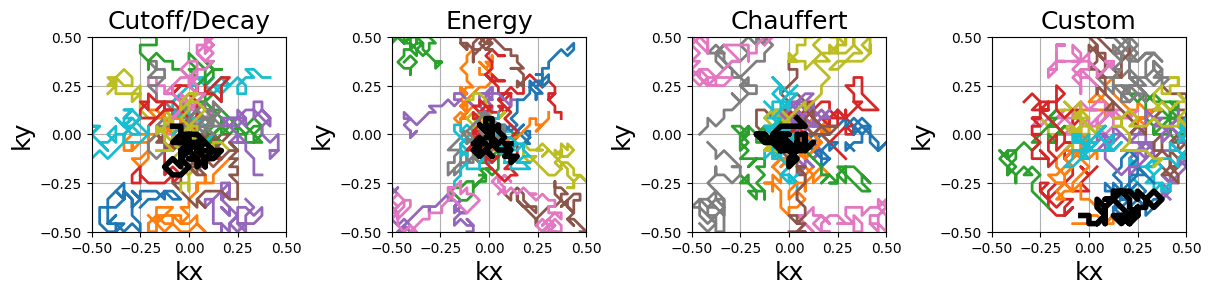

In [42]:
arguments = densities.keys()
function = lambda x: mn.initialize_2D_random_walk(
    Nc, Ns, density=densities[x][::4, ::4], method="lloyd"
)
show_trajectories(function, arguments, one_shot=one_shot, subfig_size=subfigure_size)

The random paths can be transformed into smoother trajectories by oversampling the shots with cubic splines.



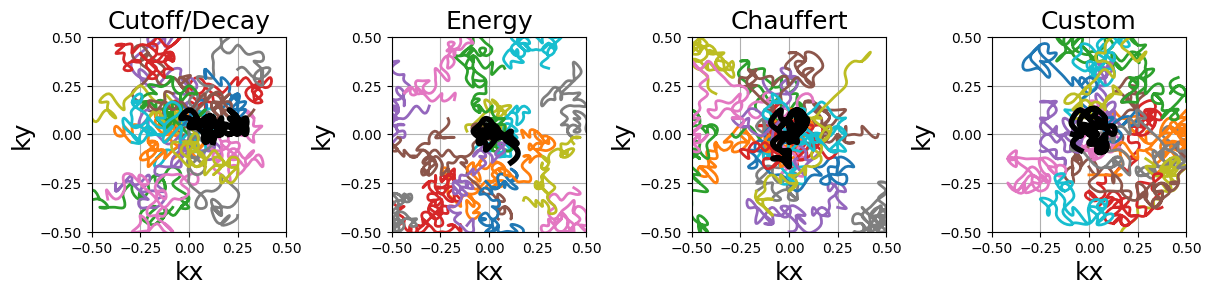

In [43]:
arguments = densities.keys()
function = lambda x: mn.oversample(
    mn.initialize_2D_random_walk(
        Nc, Ns, density=densities[x][::4, ::4], method="lloyd"
    ),
    4 * Ns,
)
show_trajectories(function, arguments, one_shot=one_shot, subfig_size=subfigure_size)

## Travelling Salesman

This is a reproduction of the work from [Cha+14]. The Travelling Salesman Problem (TSP) solution is obtained using the 2-opt method with a complexity in O(n²) in time and memory.

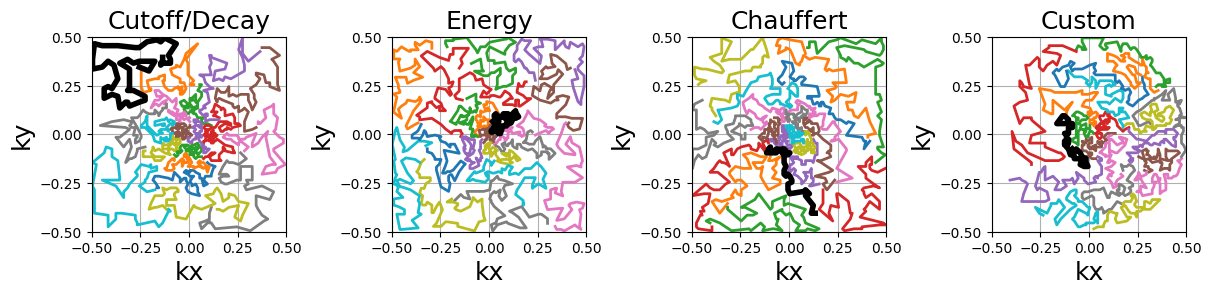

In [45]:
arguments = densities.keys()
function = lambda x: mn.initialize_2D_travelling_salesman(
    Nc,
    Ns,
    density=densities[x],
)
show_trajectories(function, arguments, one_shot=one_shot, subfig_size=subfigure_size)

It is possible to customize the sampling method using `kwargs` to provide arguments to `mrinufft.sample_from_density`. For example, one can use Lloyd’s sampling method to create evenly spaced point distributions and obtain a more deterministic coverage.

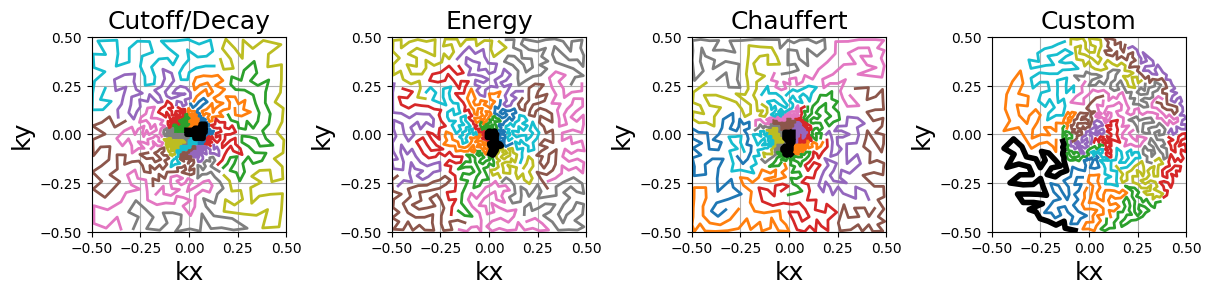

In [46]:
arguments = densities.keys()
function = lambda x: mn.initialize_2D_travelling_salesman(
    Nc,
    Ns,
    density=densities[x],
    method="lloyd",
)
show_trajectories(function, arguments, one_shot=one_shot, subfig_size=subfigure_size)

Similarly to random walks, the travelling paths can be smoothed by oversampling the shots with cubic splines. Another use case is to reduce the number of TSP points to decrease the computational load and then oversample up to the desired shot length.

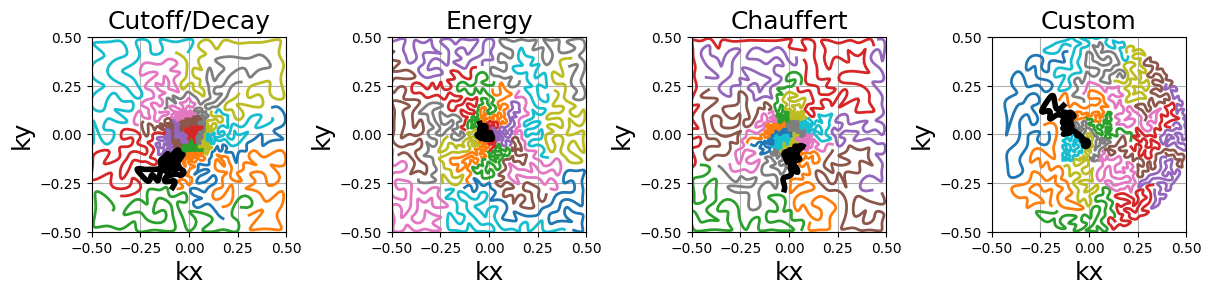

In [47]:
arguments = densities.keys()
function = lambda x: mn.oversample(
    mn.initialize_2D_travelling_salesman(Nc, Ns, density=densities[x], method="lloyd"),
    4 * Ns,
)
show_trajectories(function, arguments, one_shot=one_shot, subfig_size=subfigure_size)

An option is provided to cluster the points before calling the TSP solver, reducing drastically the computation time. Clusters are chosen by Cartesian (`"x"`, `"y"`, `"z"`) or spherical (`"r"`, `"phi"`, `"theta"`) coordinates with up to two coordinates. Then the points can be sorted out inside each cluster to define a general shot direction as shown below.

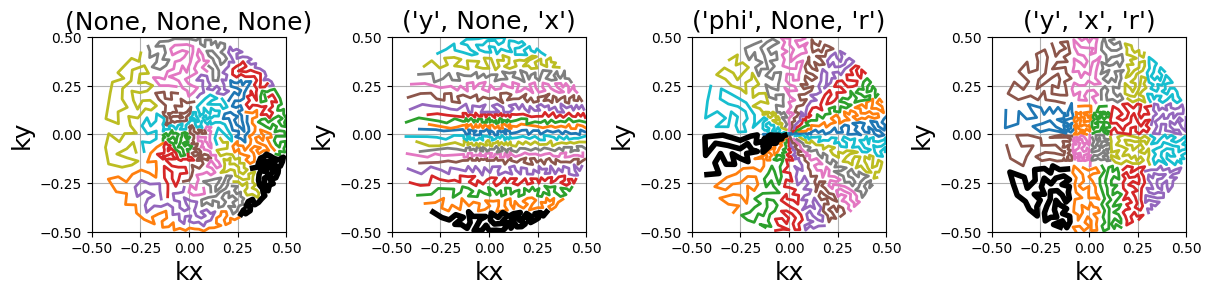

In [48]:
arguments = ((None, None, None), ("y", None, "x"), ("phi", None, "r"), ("y", "x", "r"))
function = lambda x: mn.initialize_2D_travelling_salesman(
    Nc,
    Ns,
    density=densities["Custom"],
    first_cluster_by=x[0],
    second_cluster_by=x[1],
    sort_by=x[2],
    method="lloyd",
)
show_trajectories(function, arguments, one_shot=one_shot, subfig_size=subfigure_size)

## References

[CCW13]
Chauffert, Nicolas, Philippe Ciuciu, and Pierre Weiss. “Variable density compressed sensing in MRI. Theoretical vs heuristic sampling strategies.” In 2013 IEEE 10th International Symposium on Biomedical Imaging, pp. 298-301. IEEE, 2013.

[Cha+14](1,2)
Chauffert, Nicolas, Philippe Ciuciu, Jonas Kahn, and Pierre Weiss. “Variable density sampling with continuous trajectories.” SIAM Journal on Imaging Sciences 7, no. 4 (2014): 1962-1992.

[Cha+22]
Chaithya, G. R., Pierre Weiss, Guillaume Daval-Frérot, Aurélien Massire, Alexandre Vignaud, and Philippe Ciuciu. “Optimizing full 3D SPARKLING trajectories for high-resolution magnetic resonance imaging.” IEEE Transactions on Medical Imaging 41, no. 8 (2022): 2105-2117.